In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import csv
import streamlit as st
from GHEtool import Borefield, FluidData, GroundData, PipeData
import pygfunction as gt

Input-variabler:

In [77]:
DEKGRAD = 0.90
VIRKGRAD = 0.80     #Virkningsgrad til kompressor i varmepumpen
LEDNINGSEVNE = 3.5  #Ground thermal conductivity (W/m.K) ???
UFORST_TEMP = 7.5
MIN_BRONNTEMP = 0  # Minste tillatte gjennomsnittlige temperatur til kollektorvæske


MAKS_TURTEMP = 45
MIN_TURTEMP = 35
COP_OGSAA_AVH_AV_TURTEMP = True  # True eller false                  True tar ~5 min,  False tar ~1 min


UTETEMP_FOR_MAKS_TURTEMP = -15
UTETEMP_FOR_MIN_TURTEMP = 15


ANTALL_AAR = 25
COP = 3.5                       # Resultat uavhengig av denne
DYBDE_STARTGJETT = 250          # Resultat uavhengig av denne
TERM_MOTSTAND = 0.08

Funksjoner:

In [78]:
# Funksjon for Lineær interpolering:
def lin_interp(x,x1,x2,y1,y2):
    y = y1+(x-x1)*(y2-y1)/(x2-x1)
    return y

def bronnlast_fra_COP(grunnlast,cop,virkgrad):
    ellast = grunnlast/cop#*virkgrad
    bronnlast = grunnlast-ellast

    return bronnlast


def GHE_tool_bronndybde(bronnlast,min_bronntemp,dybde_startgjett,ledningsevne,uforst_temp,term_motstand,antall_aar,bronnfelt):
    data = GroundData(ledningsevne, uforst_temp, term_motstand, 2.518 * 10**6)    # Siste parameter: Volumetric heat capacity of ground
    
    #borefield_gt = gt.boreholes.rectangle_field(N_1=ant_bronner1, N_2=ant_bronner2, B_1=10, B_2=10, H=dybde_startgjett, D = 10, r_b = 0.114) # Siste to parametre: Boreholde buried depth og borehole radius (m)
    borefield_gt = bronnfelt

    borefield = Borefield(simulation_period=antall_aar)
    borefield.set_ground_parameters(data)
    borefield.set_borefield(borefield_gt)        
    #borefield.set_hourly_heating_load(bronnlast)

    borefield.hourly_heating_load = bronnlast[-8760:]
    borefield.hourly_cooling_load = np.zeros(8760)

    borefield.set_max_ground_temperature(16)   # maximum temperature   Utgjør ingen forskjell å endre på denne.
    borefield.set_min_ground_temperature(min_bronntemp)    # minimum temperature
    dybde = borefield.size(dybde_startgjett, L4_sizing=True)
    
    snitt_koll_vaeske_temp = borefield.results_peak_heating
    bronntemp_vegg = borefield.Tb
    #SETT INN DELTA T BEREGNING
    bronntemp_tur = snitt_koll_vaeske_temp + 1.5
    bronntemp_retur = snitt_koll_vaeske_temp - 1.5


    print('Nødvendig brønndybde (GHE-tool):',dybde,'m.')
    return dybde,bronntemp_vegg,bronntemp_tur,bronntemp_retur


def kjor_pygf(bronnlast_data,bronndybde,antall_aar,ledningsevne,uforst_temp):
    # Beregning av brønntemperatur vha. Magnes pygfunction-kode:
    import pygfunction_Magne
    pygf = pygfunction_Magne.Simulation()                           # For at dette skal fungere, må det velges "Rektangulær" i pygfunction-filen
    pygf.select_borehole_field(1)               #Antall brønner 
    pygf.YEARS = antall_aar
    pygf.U_PIPE = "Single"  # Choose between "Single" and "Double"
    pygf.R_B = 0.114  # Radius (m)
    pygf.R_OUT = 0.020  # Pipe outer radius (m)
    pygf.R_IN = 0.0176  # Pipe inner radius (m)
    pygf.D_S = 0.067/2  # Shank spacing (m)
    pygf.EPSILON = 1.0e-6  # Pipe roughness (m)
    pygf.ALPHA = 1.39e-6  # Ground thermal diffusivity (m2/s)
    pygf.K_S = ledningsevne  # Ground thermal conductivity (W/m.K)            
    pygf.T_G = uforst_temp  # Undisturbed ground temperature (degrees)   
    pygf.K_G = 2  # Grout thermal conductivity (W/m.K)
    pygf.K_P = 0.42  # Pipe thermal conductivity (W/m.K)
    pygf.H = bronndybde  # Borehole depth (m)
    pygf.B = 15  # Distance between boreholes (m)
    pygf.D = 10  # Borehole buried depth
    pygf.FLOW_RATE = 0.5  # Flow rate (kg/s)
    pygf.FLUID_NAME = "MPG"  # The fluid is propylene-glycol 
    pygf.FLUID_DEGREES = 5  # at 20 \u2103
    pygf.BOUNDARY_CONDITION = 'MIFT'
    pygf.run_simulation(np.array(bronnlast_data)) #Grunnlast i enhet kW

    print(pygf.R_B)
    nybronntemp = pygf.tf_out
    returtemp = pygf.tf_in
    term_motstand = pygf.R_B
    return nybronntemp,returtemp,term_motstand


def bestem_turtemp(utetemp,utetemp_for_maks_turtemp,utetemp_for_min_turtemp,maks_turtemp,min_turtemp):
    turtemp = np.zeros(len(utetemp))
    for i in range(0,len(utetemp)):
        if utetemp[i]<utetemp_for_maks_turtemp:
            turtemp[i] = maks_turtemp
        elif utetemp[i]>utetemp_for_min_turtemp:
            turtemp[i] = min_turtemp
        else:
            #Lineær interpolering:
            turtemp[i] = lin_interp(utetemp[i],utetemp_for_maks_turtemp,utetemp_for_min_turtemp,maks_turtemp,min_turtemp)
    return turtemp


def finn_ny_COP(bronntemp_vektor,stigtall35,konstledd35,stigtall45,konstledd45,turtemp,maks_turtemp,min_turtemp):
    # COP som funksjon av turtemp (basert på COP som funksjon av brønntemp)
    nyCOP = np.zeros(len(turtemp))
    for i in range(0,len(turtemp)):
        if turtemp[i] == maks_turtemp:
            nyCOP[i] = stigtall45*bronntemp_vektor[i]+konstledd45
        elif turtemp[i] == min_turtemp:
            nyCOP[i] = stigtall35*bronntemp_vektor[i]+konstledd35
        else:
            stigtall_interp = lin_interp(turtemp[i],min_turtemp,maks_turtemp,stigtall35,stigtall45)
            konstledd_interp = lin_interp(turtemp[i],min_turtemp,maks_turtemp,konstledd35,konstledd45)
            COP_interp = stigtall_interp*bronntemp_vektor[i]+konstledd_interp
            nyCOP[i] = COP_interp
    nyCOP=np.array(nyCOP)

    COP=nyCOP
    return COP


def finn_ny_COP_konst_turtemp(bronntemp_vektor,stigtall,konstledd):
    nyCOP = stigtall * bronntemp_vektor + konstledd
    return nyCOP

Program:

In [79]:
stigtall40 = 0.07415827970667467
konstledd40 = 3.8186265651501543

Funksjonsuttrykket blir y= [0.08451848] x + [4.17957685]
Funksjonsuttrykket blir y= [0.06379808] x + [3.45767628]


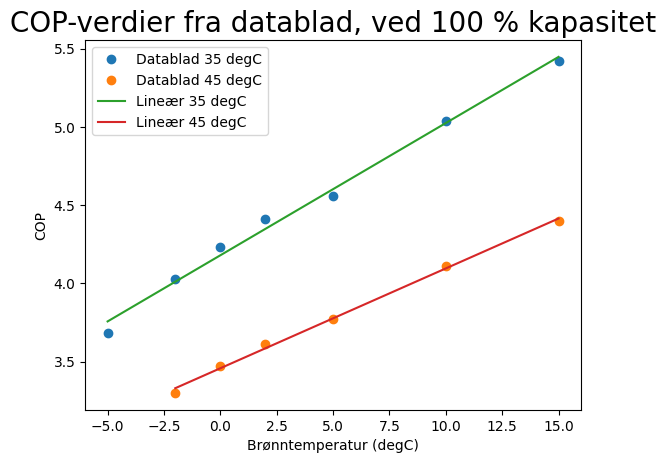

In [80]:
# COP-Verdier fra datablad
databladtemp35 = np.array([-5,-2,0,2,5,10,15])
COP_data35 = np.array([3.68, 4.03, 4.23, 4.41, 4.56, 5.04, 5.42])
databladtemp45 = np.array([-2,0,2,5,10,15])
COP_data45 = np.array([3.3, 3.47, 3.61, 3.77, 4.11, 4.4])

#Kjører lineær regresjon på COP-verdier fra datablad:
from lin_reg import *
lin_COP_data35 = lin_reg(databladtemp35,COP_data35)
lin_COP_data45 = lin_reg(databladtemp45,COP_data45)

plt.plot(databladtemp35,COP_data35,'o')
plt.plot(databladtemp45,COP_data45,'o')
plt.plot(databladtemp35,lin_COP_data35)
plt.plot(databladtemp45,lin_COP_data45)
plt.legend(['Datablad 35 \u2103', 'Datablad 45 \u2103','Lineær 35 \u2103','Lineær 45 \u2103'])
plt.xlabel('Brønntemperatur (\u2103)')
plt.ylabel('COP')
plt.title('COP-verdier fra datablad, ved 100 % kapasitet', fontsize = 20)
plt.show()

# Parametre i uttrykket for den lineære regresjonen av COP fra datablad
stigtall35 = (lin_COP_data35[-1]-lin_COP_data35[0])/(databladtemp35[-1]-databladtemp35[0])
konstledd35 = lin_COP_data35[-1]-stigtall35*databladtemp35[-1]

stigtall45 = (lin_COP_data45[-1]-lin_COP_data45[0])/(databladtemp45[-1]-databladtemp45[0])
konstledd45 = lin_COP_data45[-1]-stigtall45*databladtemp45[-1]

In [81]:
dato = []
varmelast = []
utetemp =[]
  
with open('timedata2.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter='\t')
    for row in lines:
        dato.append(row[0])
        utetemp.append(float(row[4]))
        varmelast.append(float(row[7]))

In [82]:
grunnlast = 1*varmelast
spisslast = 1*varmelast

maks = np.max(varmelast)
mini = np.min(varmelast)

for kap in np.arange(0.8*maks,mini,-0.01*maks):  #Sjekker fra 80% av makslast og nedover med steglengde 1% av denne.
    for i in range(0, len(grunnlast)):
        if grunnlast[i]>=kap:
            grunnlast[i]=kap
        else:
            grunnlast[i]=grunnlast[i]
        
    for j in range(0,len(spisslast)):
            if grunnlast[j]>=kap:
                spisslast[j]=varmelast[j]-kap
            else:
                spisslast[j]=0

    if np.sum(grunnlast)/(np.sum(varmelast))<DEKGRAD:
        break

grunnlast = np.array(grunnlast)*20
GRUNNLAST = np.hstack(ANTALL_AAR*[grunnlast])

In [83]:
DYBDE = DYBDE_STARTGJETT
if COP_OGSAA_AVH_AV_TURTEMP == True:
    turtemp = bestem_turtemp(utetemp,UTETEMP_FOR_MAKS_TURTEMP,UTETEMP_FOR_MIN_TURTEMP,MAKS_TURTEMP,MIN_TURTEMP)
    TURTEMP = np.hstack(ANTALL_AAR*[turtemp])

COP = np.array([COP]*8760*ANTALL_AAR)

dybde_GHE = DYBDE_STARTGJETT
ant_bronner1 = 1
ant_bronner2 = 1

for k in range(0,20):

    BRONNLAST = bronnlast_fra_COP(GRUNNLAST,COP,VIRKGRAD)

    bronnfelt = gt.boreholes.rectangle_field(N_1=ant_bronner1, N_2=ant_bronner2, B_1=15, B_2=15, H=dybde_GHE, D = 10, r_b = 0.114) # Siste to parametre: Boreholde buried depth og borehole radius (m)

    [dybde_GHE,bronntemp_vegg,bronntemp_tur,bronntemp_retur] = GHE_tool_bronndybde(BRONNLAST,MIN_BRONNTEMP,dybde_GHE,LEDNINGSEVNE,UFORST_TEMP,TERM_MOTSTAND,ANTALL_AAR,bronnfelt)

    maks_bronndybde = 300
    if k==0 and dybde_GHE >= maks_bronndybde:
        ant_bronner1 = math.ceil(dybde_GHE/maks_bronndybde) #runder alltid opp
        print(ant_bronner1)

    print('DYBDE:',dybde_GHE)

    if k > 0 and dybde_GHE >= maks_bronndybde:
        ant_bronner1 = ant_bronner1+1
    
    print(ant_bronner1)
    print(ant_bronner2)
    
    #[bronntemp,returtemp,TERM_MOTSTAND] = kjor_pygf(BRONNLAST,dybde_GHE,ANTALL_AAR,LEDNINGSEVNE,UFORST_TEMP)

    if COP_OGSAA_AVH_AV_TURTEMP == True:
        nyCOP = finn_ny_COP(bronntemp_tur,stigtall35,konstledd35,stigtall45,konstledd45,TURTEMP,MAKS_TURTEMP,MIN_TURTEMP)
    else:
        nyCOP = finn_ny_COP_konst_turtemp(bronntemp_tur,stigtall40,konstledd40)
    
    if np.mean(np.abs(nyCOP-COP))<0.001 and dybde_GHE<=maks_bronndybde: 
        COP = nyCOP
        if ant_bronner1 > 6:
            ant_per_side = math.ceil(np.sqrt(ant_bronner1))
            ant_bronner1 = ant_per_side
            ant_bronner2 = ant_per_side
        else:
            break
        
    else:
        COP = nyCOP


snittCOP = round(np.mean(COP),3)
print('')
print('---------------------------------------------')
print('Brønndybde: \t \t',round(dybde_GHE,3),'m')
print('Minste turtemp: \t',round(np.min(bronntemp_tur),3),'\u2103')
print('Minste returtemp: \t',round(np.min(bronntemp_retur),3),'\u2103')
print('Minste veggtemp: \t',round(np.min(bronntemp_vegg),3),'\u2103')
print('Gjennomsnittlig COP: \t',snittCOP)
print('Laveste COP-verdi: \t',round(np.min(COP),3))
print('')
print('Brønnlast gitt denne COP:')
print(BRONNLAST)
print('')
print(bronntemp_tur)
print(bronntemp_retur)
    

Nødvendig brønndybde (GHE-tool): 2325.93278380882 m.
8
DYBDE: 2325.93278380882
8
1
Nødvendig brønndybde (GHE-tool): 399.47426036232486 m.
DYBDE: 399.47426036232486
9
1
Nødvendig brønndybde (GHE-tool): 356.4868566660431 m.
DYBDE: 356.4868566660431
10
1
Nødvendig brønndybde (GHE-tool): 321.79867075223575 m.
DYBDE: 321.79867075223575
11
1
Nødvendig brønndybde (GHE-tool): 293.0220985071049 m.
DYBDE: 293.0220985071049
11
1
Nødvendig brønndybde (GHE-tool): 271.7086895388198 m.
DYBDE: 271.7086895388198
4
4
Nødvendig brønndybde (GHE-tool): 271.48602731130904 m.
DYBDE: 271.48602731130904
4
4

---------------------------------------------
Brønndybde: 	 	 271.486 m
Minste turtemp: 	 1.5 degC
Minste returtemp: 	 -1.5 degC
Minste veggtemp: 	 1.048 degC
Gjennomsnittlig COP: 	 4.242
Laveste COP-verdi: 	 3.56

Brønnlast gitt denne COP:
[32.9948349  32.35594547 33.7611815  ... 55.99297946 56.01902996
 56.04496902]

[8.34310323 8.28260949 8.2038529  ... 1.554475   1.553718   1.55284612]
[ 5.34310323  5.

Diagrammer:

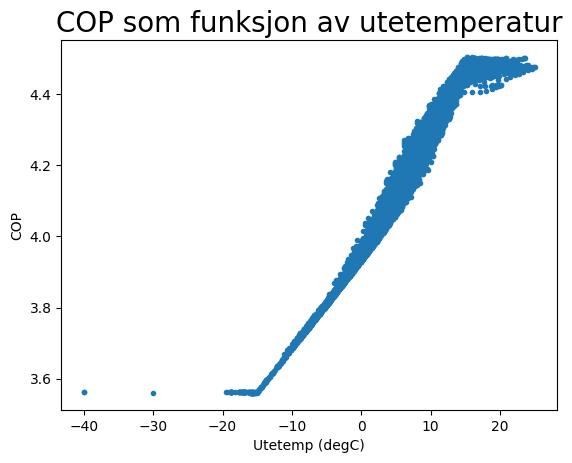

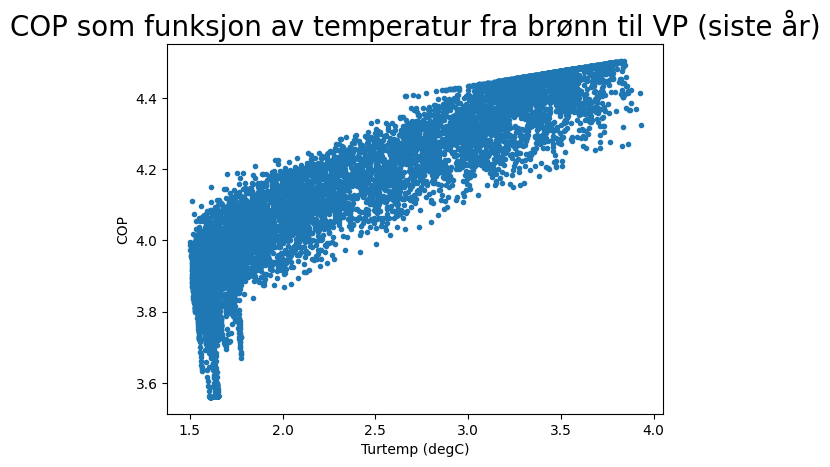

In [84]:
plt.plot(utetemp,COP[-8760:],'.')
plt.title(('COP som funksjon av utetemperatur'), fontsize = 20)
plt.xlabel('Utetemp (\u2103)')
plt.ylabel("COP")
#plt.legend(['Returtemperatur til brønn','Brønntemperatur'])
plt.show()

plt.plot(bronntemp_tur[-8760:],COP[-8760:],'.')
plt.title(('COP som funksjon av temperatur fra brønn til VP (siste år)'), fontsize = 20)
plt.xlabel('Turtemp (\u2103)')
plt.ylabel("COP")
#plt.legend(['Returtemperatur til brønn','Brønntemperatur'])
plt.show()

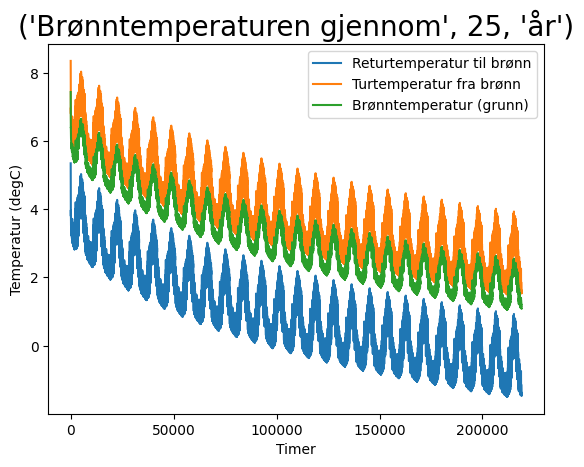

In [85]:
plt.plot(bronntemp_retur)
plt.plot(bronntemp_tur)
plt.plot(bronntemp_vegg)
plt.title(('Brønntemperaturen gjennom', ANTALL_AAR, 'år'), fontsize = 20)
plt.xlabel('Timer')
plt.ylabel("Temperatur (\u2103)")
plt.legend(['Returtemperatur til brønn','Turtemperatur fra brønn','Brønntemperatur (grunn)'])
plt.show()

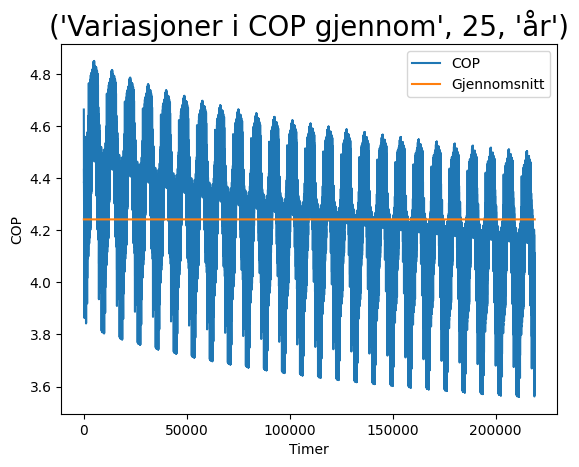

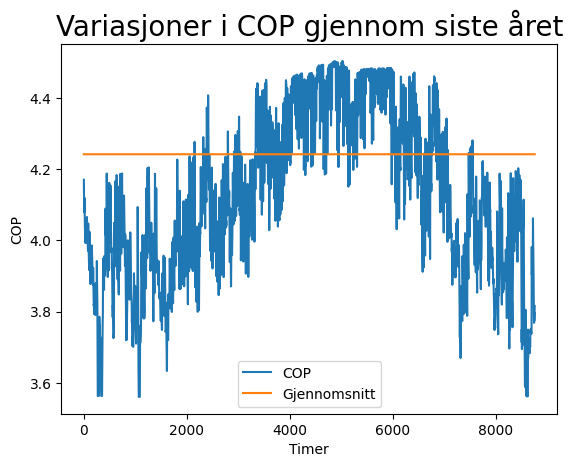

In [86]:
plt.plot(COP)
plt.plot(np.array([snittCOP]*len(COP)))
plt.title(('Variasjoner i COP gjennom', ANTALL_AAR, 'år'), fontsize = 20)
plt.xlabel('Timer')
plt.ylabel("COP")
plt.legend(['COP','Gjennomsnitt'])
plt.show()

plt.plot(COP[-8760:])
plt.plot(np.array([snittCOP]*8760))
plt.title('Variasjoner i COP gjennom siste året', fontsize = 20)
plt.xlabel('Timer')
plt.ylabel("COP")
plt.legend(['COP','Gjennomsnitt'])
plt.show()

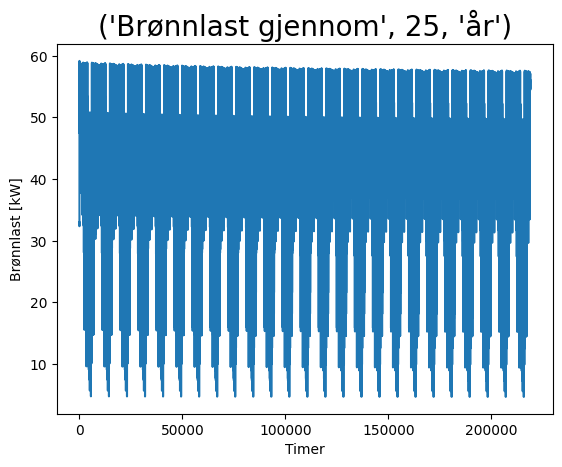

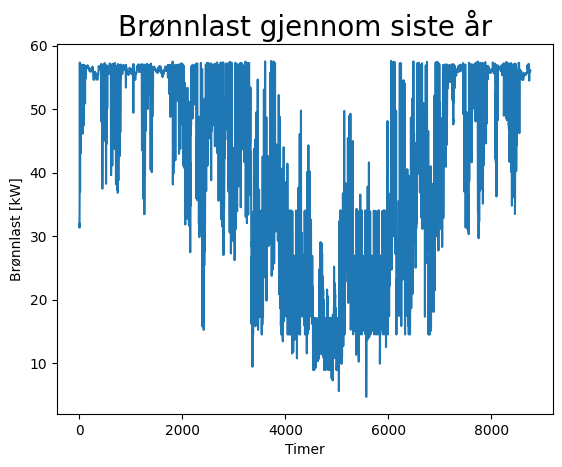

In [87]:
plt.plot(BRONNLAST)
plt.title(('Brønnlast gjennom', ANTALL_AAR, 'år'), fontsize = 20)
plt.xlabel('Timer')
plt.ylabel("Brønnlast [kW]")
#plt.legend(['COP','Gjennomsnitt'])
plt.show()

plt.plot(BRONNLAST[-8760:])
plt.title(('Brønnlast gjennom siste år'), fontsize = 20)
plt.xlabel('Timer')
plt.ylabel("Brønnlast [kW]")
#plt.legend(['COP','Gjennomsnitt'])
plt.show()

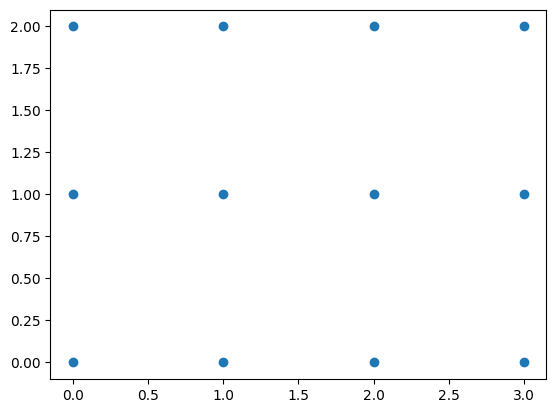

In [7]:

r = 3
c = 4

x = [i % c for i in range(r*c)]
y = [i // c for i in range(r*c)]

plt.scatter(x,y)
plt.show()
